In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [4]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload your file


Saving volkswagen_oem_transactions_expanded_parts_with_duplicates.csv to volkswagen_oem_transactions_expanded_parts_with_duplicates.csv


**Load your dataset**

In [5]:
data = pd.read_csv("volkswagen_oem_transactions_expanded_parts_with_duplicates.csv")
data.head()

,transaction_id,part_number,part_description,quantity_ordered,unit_price,total_amount,invoice_number,supplier_id,supplier_location,warehouse_location,currency,orer_ID,order_date,payment_method,payment_date
0,fb80c938-d697-4b58-8afe-c671ad90ed3c,1K0-129-618-AN,Suspension Spring,54,80.41,4342.14,5727947101724,1109,French Southern Territories,Emden,USD,7dc3ea77-668a-4f5d-b8bd-c5d170c20b77,2024-01-22,credit_card,2024-02-05
1,c0719de9-9655-4d59-8dcc-269c4a67b169,4G0-941-591-A,Headlight,41,282.39,11577.99,9209395215438,1310,Cook Islands,Wolfsburg,GBP,088d73ba-3799-49cb-a998-95fe3522f3cb,2024-02-02,credit_card,2024-02-15
2,08da9828-30be-46a1-a9f2-b428eb72f6d1,03C-115-561-D,Oil Filter Housing,94,53.72,5049.68,1057081902487,1371,Saint Helena,Wolfsburg,EUR,0802d749-f837-4dd2-884b-24e4ba72e329,2024-01-05,paypal,2024-01-25
3,105617eb-7980-4e0d-9623-121f85854e8b,06A-198-141-F,Clutch Kit,42,603.81,25360.02,8268387078957,1428,Italy,Emden,USD,c7e9ffc3-b18e-4e2e-bf02-0c2a41fd6899,2024-05-25,paypal,2024-07-10
4,f453861a-66e8-40ed-a57c-5360667a5488,1J1-422-055-K,Rack and Pinion,19,75.24,1429.56,5430239273992,1614,Mexico,Hanover,USD,617bc6ab-b8b0-4ee5-9e1a-022a125c4cd8,2024-06-11,paypal,2024-06-25


In [6]:
data.isnull().sum()

,0
transaction_id,0
part_number,0
part_description,0
quantity_ordered,0
unit_price,0
total_amount,0
invoice_number,0
supplier_id,0
supplier_location,0
warehouse_location,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40800 entries, 0 to 40799
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      40800 non-null  object 
 1   part_number         40800 non-null  object 
 2   part_description    40800 non-null  object 
 3   quantity_ordered    40800 non-null  int64  
 4   unit_price          40800 non-null  float64
 5   total_amount        40800 non-null  float64
 6   invoice_number      40800 non-null  int64  
 7   supplier_id         40800 non-null  int64  
 8   supplier_location   40800 non-null  object 
 9   warehouse_location  40800 non-null  object 
 10  currency            40800 non-null  object 
 11  orer_ID             40800 non-null  object 
 12  order_date          40800 non-null  object 
 13  payment_method      40800 non-null  object 
 14  payment_date        40800 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 4.7

In [8]:
data.describe()

,quantity_ordered,unit_price,total_amount,invoice_number,supplier_id
count,40800.000000,40800.000000,40800.000000,4.080000e+04,40800.000000
mean,50.285025,524.392554,26316.923781,4.987029e+12,1501.063799
std,28.802396,274.569119,27944.091953,2.882423e+12,290.401629
min,1.000000,50.010000,-270878.930000,5.138465e+07,1000.000000
25%,25.000000,287.377500,7970.475000,2.484179e+12,1247.000000
50%,50.000000,523.330000,20090.880000,4.987243e+12,1502.000000
75%,75.000000,761.260000,39807.962500,7.472725e+12,1755.000000
max,100.000000,999.940000,453626.600000,9.999889e+12,2000.000000


**Calculate time difference**

In [34]:
data['payment_date'] = pd.to_datetime(data['payment_date'])
data['order_date'] = pd.to_datetime(data['order_date'])

# Calculate time difference
data['time_difference'] = (data['payment_date'] - data['order_date']).dt.days

# Filter data to exclude time differences less than 5 days
filtered_data = data[(data['time_difference'] >= 40)]



In [35]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(filtered_data[['time_difference']])

# Define the autoencoder model
input_dim = X.shape[1]
encoding_dim = 14  # Adjust based on your data

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='tanh')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X, X, epochs=20, batch_size=40, shuffle=True, validation_split=0.2)
#anomoly due to irregular payment timeing
# Predict and calculate reconstruction error
reconstructed = autoencoder.predict(X)
reconstruction_error = np.mean(np.power(X - reconstructed, 2), axis=1)

# Set a threshold for anomalies
threshold = 0.1  # Adjust based on your analysis
anomalies_autoencoder = filtered_data[reconstruction_error > threshold]
print("Anomalies detected using Autoencoder:")
print(anomalies_autoencoder)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8021 - val_loss: 0.5604
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5147 - val_loss: 0.4820
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4614 - val_loss: 0.4650
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4365 - val_loss: 0.4571
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4202 - val_loss: 0.4522
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4247 - val_loss: 0.4497
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4133 - val_loss: 0.4482
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4093 - val_loss: 0.4476
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4235 - val_loss: 0.4474
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4306 - val_loss: 0.4472
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4061 - val_loss: 0.4472
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4211 - val_lo

In [36]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X)

# Predict anomalies
filtered_data['anomaly'] = iso_forest.predict(X)

# Anomalies are marked as -1
anomalies_isolation_forest = filtered_data[filtered_data['anomaly'] == -1]
print("Anomalies detected using Isolation Forest:")
print(anomalies_isolation_forest)

Anomalies detected using Isolation Forest:
                             transaction_id     part_number  \
110    3598151a-346b-44a9-b85d-ab0dd149864c   1K0-820-803-S   
118    4d35a437-0126-499c-aa84-96b284509813   1J0-199-555-K   
125    b36f11e0-4dab-4398-97ea-c531c9565fee   6Q0-919-051-H   
508    f9e28993-8a0c-4c1e-b612-3ca5341b9756     1J1-955-425   
511    296ac766-546f-4153-8488-c0a9364859c0   6Q0-412-331-C   
...                                     ...             ...   
39936  b44fcbad-16a6-44af-a174-4451e1e350dd   8D0-407-365-C   
40236  b9daa4ab-d23d-47cb-b4cc-77739824d76f   1K0-820-803-S   
40491  51f9ca39-0c09-418d-9bae-589dbad3ed1d   06J-253-033-B   
40626  57e0b342-062b-44e1-ae07-826f6e7d766b  1K0-131-701-AR   
40790  6d56b185-c0b5-40af-b341-3a76a9398981   1C0-907-530-K   

          part_description  quantity_ordered  unit_price  total_amount  \
110          AC Compressor                19      866.17      16457.23   
118     Transmission Mount                46      34

<ipython-input-36-9d44c5edbb75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['anomaly'] = iso_forest.predict(X)


Anomalies detected:
                             transaction_id     part_number  \
110    3598151a-346b-44a9-b85d-ab0dd149864c   1K0-820-803-S   
118    4d35a437-0126-499c-aa84-96b284509813   1J0-199-555-K   
167    b4804f63-e731-4364-b53b-31ab9c7da957   06F-133-681-C   
192    efcec1df-8d28-47e9-888c-74d362fb277b     1J1-955-425   
267    c39adb41-b2e7-4e86-ba76-943480371a2a   06A-905-377-A   
...                                     ...             ...   
39895  e7df96e0-6361-4e19-8b61-b00bf58a93e7  1J0-201-021-AG   
40236  b9daa4ab-d23d-47cb-b4cc-77739824d76f   1K0-820-803-S   
40395  7a48eac4-b2a4-4415-8b13-f2d8cb0fb729   06F-133-681-C   
40481  6cadea39-5f56-4fad-9900-e64442e54b5f     1J0-498-625   
40790  6d56b185-c0b5-40af-b341-3a76a9398981   1C0-907-530-K   

         part_description  quantity_ordered  unit_price  total_amount  \
110         AC Compressor                19      866.17      16457.23   
118    Transmission Mount                46      343.92      15820.32   
167 

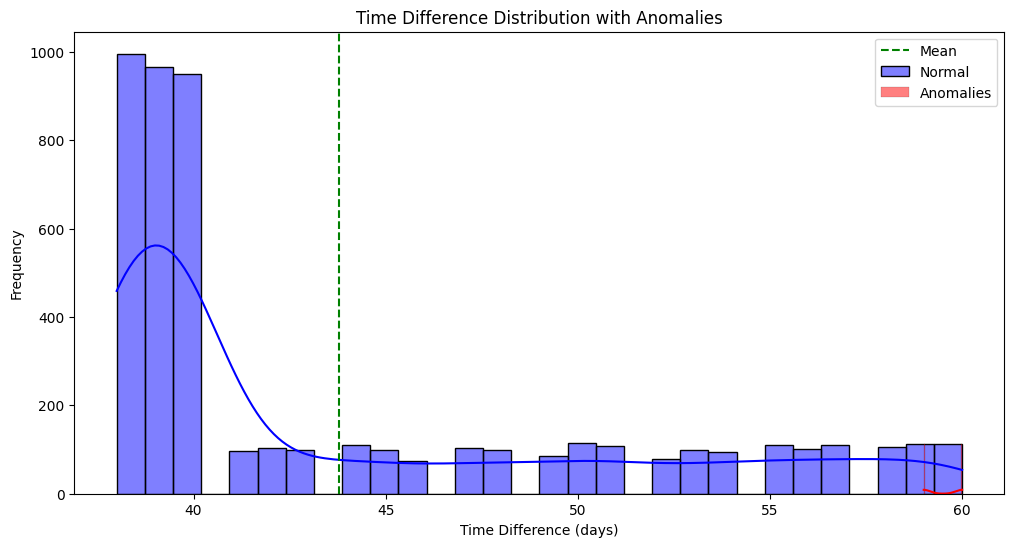

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    # Load dataset from CSV
    data = pd.read_csv(file_path)

    # Convert date columns to datetime format
    data['payment_date'] = pd.to_datetime(data['payment_date'], errors='coerce')
    data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce')

    # Drop rows with NaT in date columns
    data.dropna(subset=['payment_date', 'order_date'], inplace=True)

    # Calculate time difference
    data['time_difference'] = (data['payment_date'] - data['order_date']).dt.days

    # Filter data to exclude unrealistic time differences
    data = data[(data['time_difference'] >= 38)]

    return data

# Function to detect anomalies using Isolation Forest
def detect_anomalies(data):
    # Normalize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(data[['time_difference']])

    # Initialize Isolation Forest with a specific contamination level
    iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination as needed
    iso_forest.fit(X)

    # Predict anomalies
    data['anomaly'] = iso_forest.predict(X)
    anomalies = data[data['anomaly'] == -1]

    return anomalies

# Function to visualize results
def visualize_results(data, anomalies):
    plt.figure(figsize=(12, 6))
    sns.histplot(data['time_difference'], bins=30, kde=True, color='blue', label='Normal', alpha=0.5)
    sns.histplot(anomalies['time_difference'], bins=30, kde=True, color='red', label='Anomalies', alpha=0.5)
    plt.axvline(x=data['time_difference'].mean(), color='green', linestyle='--', label='Mean')
    plt.title('Time Difference Distribution with Anomalies')
    plt.xlabel('Time Difference (days)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Main function to execute the workflow
def main(file_path):
    data = load_and_preprocess_data(file_path)
    anomalies = detect_anomalies(data)

    print("Anomalies detected:")
    print(anomalies)

    visualize_results(data, anomalies)

# Execute the main function
if __name__ == "__main__":
    file_path = 'volkswagen_oem_transactions_expanded_parts_with_duplicates.csv'  # Replace with your actual file path
    main(file_path)

Unusual Values detected:
                             transaction_id     part_number  \
81     9ee7e9bf-a750-43bc-be60-32d014793b22   357-129-625-A   
279    d2ad461e-fc48-4032-9291-3ea7cf352c90   1J0-422-155-E   
399    c8add38f-5139-4e00-9d14-f464bc19f780   06A-105-323-P   
654    f0517441-9ce8-4631-bc21-883b6a0fd41a   03C-121-004-J   
670    d899f69e-fb07-4c8d-b469-5368dd22b8fc  09G-927-750-AT   
...                                     ...             ...   
40663  c506096e-3cf3-45e3-9600-6d872d766afb   1K0-820-411-P   
40684  1e7f4706-a57f-4b6f-a596-fd8483c673c9   06A-105-323-P   
40688  261a536d-fd4a-4ae0-b4ab-6dee0133fc2d   06K-145-702-N   
40738  0527ce1c-ffbf-4bbf-b33e-869f3dc544be  1K0-122-101-AC   
40798  0cae5f52-7729-4853-9024-f663df469b49   1J0-819-031-B   

          part_description  quantity_ordered  unit_price  total_amount  \
81              Air Filter                65      635.29    -106443.26   
279    Power Steering Pump                71      909.63     -12849.82

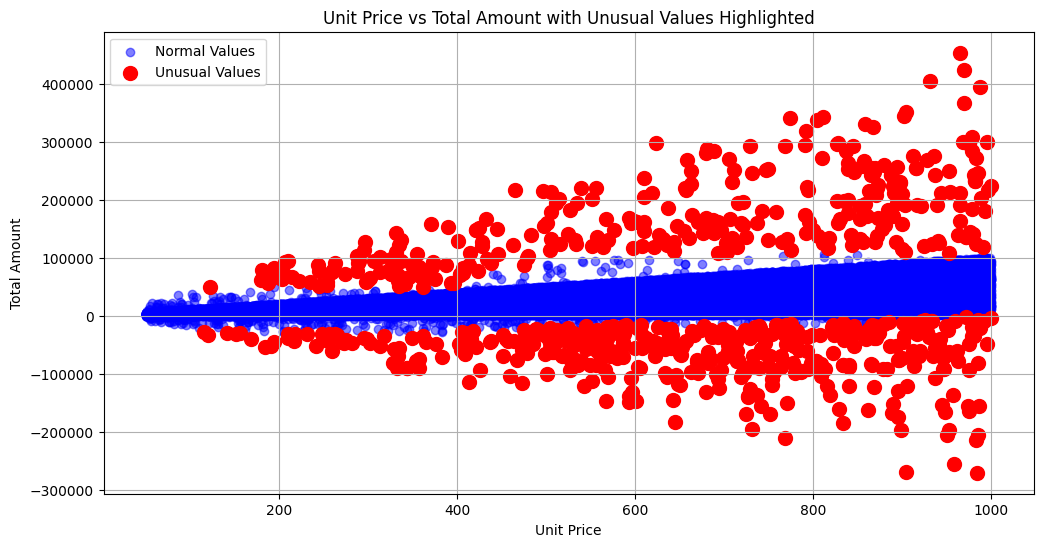

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    # Load dataset from CSV
    data = pd.read_csv(file_path)

    # Drop rows with NaN values in the relevant columns
    data.dropna(subset=['unit_price', 'total_amount'], inplace=True)

    return data

# Function to detect unusual values using K-Means
def detect_unusual_values(data, n_clusters=3):
    # Extract relevant features
    features = data[['unit_price', 'total_amount']].values

    # Normalize the data
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['cluster'] = kmeans.fit_predict(features_scaled)

    # Calculate distances to cluster centers
    data['distance_to_center'] = np.linalg.norm(features_scaled - kmeans.cluster_centers_[data['cluster']], axis=1)

    # Define a threshold for unusual values (e.g., 1.5 times the standard deviation)
    threshold = np.mean(data['distance_to_center']) + 1.5 * np.std(data['distance_to_center'])
    unusual_values = data[data['distance_to_center'] > threshold]

    return unusual_values

# Function to visualize results
def visualize_results(data, unusual_values):
    plt.figure(figsize=(12, 6))

    # Scatter plot for unit_price vs total_amount
    plt.scatter(data['unit_price'], data['total_amount'], alpha=0.5, label='Normal Values', color='blue')

    # Highlight unusual values
    plt.scatter(unusual_values['unit_price'], unusual_values['total_amount'],
                color='red', label='Unusual Values', s=100)

    plt.title('Unit Price vs Total Amount with Unusual Values Highlighted')
    plt.xlabel('Unit Price')
    plt.ylabel('Total Amount')
    plt.legend()
    plt.grid()
    plt.show()

# Main function to execute the workflow
def main(file_path):
    data = load_and_preprocess_data(file_path)
    unusual_values = detect_unusual_values(data)

    print("Unusual Values detected:")
    print(unusual_values)

    visualize_results(data, unusual_values)

# Execute the main function
if __name__ == "__main__":
    file_path = 'volkswagen_oem_transactions_expanded_parts_with_duplicates.csv'  # Replace with your actual file path
    main(file_path)